In [3]:
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')



import mujoco
print("Mujoco Version : ", mujoco.__version__)
mujoco.MjModel.from_xml_string('<mujoco/>') #empty model

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Mujoco Version :  2.3.6


In [4]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml) #The from_xml_string() method invokes the model compiler, which creates a binary mjModel instance.

In [5]:
model.ngeom

2

In [6]:
model.geom_rgba

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

In [7]:
try:
  model.geom()
except KeyError as e:
  print(e)

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


In [8]:
model.geom('green_sphere')


<_MjModelGeomViews
  bodyid: array([0])
  conaffinity: array([1])
  condim: array([3])
  contype: array([1])
  dataid: array([-1])
  friction: array([1.   , 0.005, 0.   ])
  gap: array([0.])
  group: array([0])
  id: 1
  margin: array([0.])
  matid: array([-1])
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0])
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2])
  user: array([], dtype=float64)
>

In [9]:
model.geom('green_sphere').rgba

array([0., 1., 0., 1.], dtype=float32)

In [10]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

In [11]:
print('id of "green_sphere": ', model.geom('green_sphere').bodyid)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  [0]
name of geom 1:  green_sphere
name of body 0:  world


In [12]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

In [13]:
data = mujoco.MjData(model)

In [14]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


In [15]:
print(data.time) # time 
print(data.qpos) # generalized positions
print(data.qvel) # generalized velocities

0.0
[]
[]


In [16]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


""

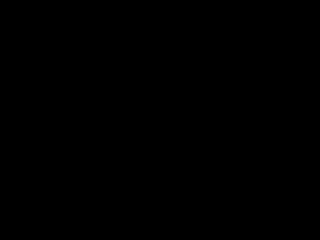

In [17]:
# plt.imshow(np.zeros((300,300,3)))
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
media.show_image(renderer.render())

2245128


""

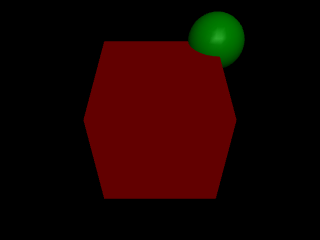

In [19]:
mujoco.mj_forward(model, data) #have to propagate ; otherwise, it gives null image..like above
renderer.update_scene(data)
pixels = renderer.render()
print(np.sum(pixels))
media.show_image(pixels)

""

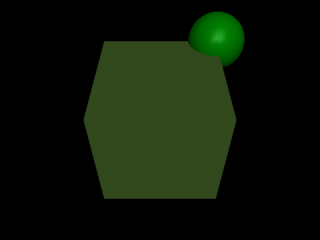

In [20]:
# Run this cell multiple times for different colors
model.geom('red_box').rgba[:3] = np.random.rand(3)
renderer.update_scene(data)
media.show_image(renderer.render())

In [23]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render()
    # print(np.sum(pixels))
    frames.append(pixels)
media.show_video(frames, fps=framerate)

In [12]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba=".3 .5 .3 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        # print(np.sum(pixels))
        
        frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

In [10]:
model.opt.timestep

0.002

In [17]:
print('default gravity', model.opt.gravity)
model.opt.gravity = (0, 0, 10)
print('flipped gravity', model.opt.gravity)

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=60)

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


In [16]:
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

Total number of DoFs in the model: 1
Generalized positions: [-0.017]
Generalized velocities: [0.794]


In [4]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="closeup")
# media.show_image(renderer.render())

In [5]:
print('positions', data.qpos)
print('velocities', data.qvel)

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


In [6]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)